In [1]:
import numpy as np
import pandas as pd
import time, os, sys
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.metrics import precision_recall_fscore_support, classification_report, adjusted_mutual_info_score
from sklearn.metrics import multilabel_confusion_matrix

In [3]:
import tcremb.ml_utils as ml_utils
import benchmark.models as models
import benchmark.metrics as metrics
#import benchmark.models_tcrdist as models_tcrdist

# Clustering

## VDJdb

In [4]:
vdjdb_data_path = '/home/ykremlyakova/projects/tcr_emb/data/data_preped/VDJdb_data.csv'

In [5]:

vdjdb_data = pd.read_csv(vdjdb_data_path,sep='\t')

In [6]:
def precision_recall_fscore(df, ytrue, ypred, label):

    labels = np.unique(ytrue)
    precisions = []# per epitope
    recalls = []# per epitope
    accuracies = [] # per epitope
    weights = []# per epitope
    supports = []

    fn_per_epi = df[df['cluster'].isnull()][label].value_counts() # Retain value counts for false negatives
    
    epmetrics = {'accuracy':{},
                 'precision': {},
                 'recall': {},
                 'f1-score': {},
                 'support': {}}
    for (i, cm) in enumerate(multilabel_confusion_matrix(ytrue, 
                                                         ypred, 
                                                         labels=labels)):# per epitope
        # for order see https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html
        tn = cm[0][0]
        fn = cm[1][0]
        tp = cm[1][1]
        fp = cm[0][1]
        lbl = labels[i]

        missing_fn = fn_per_epi.get(lbl, 0) 
        fn += missing_fn

        if tp+fp == 0:
            precision = 0.0
        else:
            precision = tp/(tp+fp)

        if tp+fn == 0:
            recall = 0.0
        else:
            recall = tp/(tp+fn)
        
        if tp + tn == 0:
            accuracy = 0
        else:
            accuracy = (tp + tn ) / (tp + tn + fp + fn)


        # weighting='average'
        support = sum(ytrue == lbl)
        w = support/ytrue.shape[0]
        weights.append(w)
        
        precision *= w
        recall *= w
        accuracy *=w

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        supports.append(support)

        epmetrics['accuracy'][labels[i]]= accuracy
        epmetrics['precision'][labels[i]]= precision
        epmetrics['recall'][labels[i]]= recall
        if ((precision * recall ==0)|(precision + recall ==0)):
            f = 0
        else:
            f = 2* (precision * recall) / (precision + recall)

        epmetrics['f1-score'][labels[i]]= f
        epmetrics['support'][labels[i]]=support
                               
    # deal with epitopes for which we had no prediction 
    uncalled_epis = set(df[label]).difference(labels)
    if len(uncalled_epis)!=0:
        print('No predictions made for: ',uncalled_epis)
    for i in uncalled_epis:

        accuracy = 0
        precision = 0
        recall = 0
        fscore = 0
        support = sum(ytrue == i)
        recalls.append(recall)
        precisions.append(precision)
        supports.append(sum(ytrue == i))

        epmetrics['accuracy'][i]= accuracy
        epmetrics['precision'][i]= precision
        epmetrics['recall'][i]= recall
        epmetrics['f1-score'][i]= fscore
        epmetrics['support'][i]=support

    recall = sum(recalls)
    precision = sum(precisions)
    support = sum(supports)

    if ((precision * recall == 0)|(precision + recall == 0)):
        f = 0
    else:
        f = 2* (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f, support, epmetrics

In [7]:
def get_clustermetrics(data_df, label):

    binom_res = data_df[['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()
    
    # Find clustered TCRs
    df = data_df[data_df['is_cluster']==1]

    # Compute overall purity metrics
    purity = ml_utils.count_clstr_purity(binom_res)
    #stats = get_purity(df)

    # Compute predictive metrics
    ypred = df['label_cluster']
    ytrue = df[label]
    ami = adjusted_mutual_info_score(ytrue,ypred)
    accuracy, precision, recall, f1score, support, epmetrics = precision_recall_fscore(
            df, ytrue, ypred, label)
    ami = adjusted_mutual_info_score(ytrue, ypred)

    counts = {k:v for k,v in df[label].value_counts().reset_index().values.tolist()}
    maincluster = {ep: df[df[label]==ep]['cluster'].value_counts().index[0] for ep in df[label].unique()} # Find the largest cluster per epitope
    #mosfreq = stats['most_frequent']    # Find the most frequent epitope per cluster
    #clusts = {ep: '-1' if ep not in list(mosfreq.values()) else [c for c in mosfreq.keys() if mosfreq[c]==ep] for ep in counts.keys()} # Map epitopes to the clusters in which they are most frequent
    #puritymap = {ep: 0 if clusts[ep]=='-1' else np.mean([len(sub[(sub['cluster']==c)&(sub['epitope']==ep)])/len(sub[sub['cluster']==c]) for c in clusts[ep]]) for ep in clusts.keys()} # Get purity per epitope
    #retmap = {ep: len(df[(df['epitope']==ep)&(~df['cluster'].isnull())])/len(df[df['epitope']==ep]) for ep in counts.keys()} # Get retention scores per epitope
    consistencymap = {ep: len(df[(df[label]==ep)&(df['cluster']==maincluster[ep])])/counts[ep] for ep in counts.keys()}  # Get consistency scores per epitope
    #epmetrics['consistency']=consistencymap
    #epmetrics['retention']=retmap
    #epmetrics['purity']=puritymap
    
    return {'purity':purity,
        #'purity': np.mean(list(binom_res[binom_res['is_cluster']==1]['fraction_matched'])),           # Purity of all clusters weighted equally (frequency)
            #'purity_enriched': np.mean(list(stats['purity_enriched'].values())),  # Purity of clusters (enrichment)
            'retention': len(data_df[data_df['is_cluster']==1])/len(data_df), # Proportion of clustered TCRs
            'consistency': np.mean([(consistencymap[ep]*counts[ep])/len(df) for ep in consistencymap.keys()]), # Proportion of an epitope assigned to a given cluster
            'ami':ami,  # Adjusted mutual information
            'accuracy':accuracy,    # Balanced accuracy
            'precision':precision,  # Precision over all epitopes
            'recall':recall,    # Recall over all epitopes
            'f1-score':f1score, # F1 over all epitopes
            'support':support,  # Support
            #'epscores': epmetrics,
            'mean_clustsize': np.mean(list(binom_res[binom_res['is_cluster']==1]['total_cluster'])), # Average cluster size
            #'small_clusters': stats['Nd'],    # Number of clusters with ≤ 10 members
            } 

In [8]:
def tcrdist3_dist(data_df, chain, n_clusters=None, chunk=True):
    df = data_df.copy()
    cdr3a = 'cdr3_a_aa'
    va = 'v_a_gene'
    ja = 'j_a_gene'
    cdr3b = 'cdr3_b_aa'
    vb = 'v_b_gene'
    jb = 'j_b_gene'

    if not 'count' in df.columns:
        df['count']=[1]*len(df)

    if chain == 'TRA':
        df = df[df['chain']==chain].reset_index(drop=True)
        df = df.rename(columns={'cdr3aa': cdr3a,
                                                'v': va,
                                                'j':ja})
        df = df[[cdr3a, va, ja,'antigen.epitope', 'count','data_id']]

    elif chain == 'TRB':
        df = df[df['chain']==chain].reset_index(drop=True)
        df= df.rename(columns={'cdr3aa': cdr3b,
                                                'v': vb,
                                                'j':jb})
        df = df[[cdr3b, vb, jb,'antigen.epitope', 'count','data_id']]

    else:
        pass


    seqs = df.drop(columns=['antigen.epitope','data_id'], axis=1).reset_index(drop=True)

    if chain =='TRA':
        chain1 = ['alpha']
    else:
        chain1 = ['beta']

    # Run tcrdist3

    print('\n*** Tcrdist3 clustering %s %s chains ' % (len(seqs), chain))

    t0 = time.time()

    # Create tcrdist object
    tr = TCRrep(cell_df=seqs,   # Input data
                organism='human',   # Organism
                chains=chain1,       # Chain selection
                infer_all_genes=True,   # Infer genes
                infer_cdrs=True,        # Infer CDRs
                infer_index_cols=True,  # Infer column names
                store_all_cdr=True,     # Store CDRs
                deduplicate=False,      # Deduplicate
                compute_distances=False)    # Compute distances
    return tr, df
    
    # Compute tcrdist distances using sparse rect distances
def tcrdist3_compute(tr, chain, cpus, radius=50):
    if chain =='TRA':
        chain1 = ['alpha']
        name = 'alpha'
    else:
        chain1 = ['beta']
        name = 'beta'


    S, _ = compute_pw_sparse_out_of_memory2(tr = tr,
        row_size      = 50,
        pm_processes  = cpus,
        pm_pbar       = True,
        max_distance  = radius,
        reassemble    = True,
        cleanup       = True,
        assign        = True)
    S=S[name]

    return S   

    # Cluster tcrdist matrix
def tcrdust3_cluster(S, chain, n_clusters):
    if not n_clusters:
        n_clusters=500
    kmeans = KMeans(init='random',
                    n_init=10,
                    n_clusters=int(n_clusters)).fit(S)
    labels = kmeans.labels_
    
    pd.DataFrame(labels).to_csv()

    return labels

def run_tcrdist3(vdjdb_data_tcrdist3, chain, n_clusters):
    tcrdist3_tr, tcrdist_data = tcrdist3_dist(vdjdb_data_tcrdist3,chain)
    tcrdist3_s = tcrdist3_compute(tcrdist3_tr,chain,2)
    tcrdist3_labels = tcrdust3_cluster(tcrdist3_s, chain, n_clusters)
    tcrdist_data['cluster']= tcrdist3_labels
    binom_res = ml_utils.binominal_test(tcrdist_data, 'cluster', 'antigen.epitope')
    binom_res = binom_res.rename({'antigen.epitope':'label_cluster'},axis=1)
    tcrdist_data = tcrdist_data.merge(binom_res)
    tcrdist_data.to_csv(f'benchmark/outputs/tcrdist_res_{chain}.txt',sep='\t')
    return tcrdist_data


def run_GIANA(data_df, chain, cpus):
    '''Run GIANA clustering algorithm
'''
    df = data_df[data_df['chain']==chain][['cdr3aa','v','antigen.epitope','data_id']].reset_index(drop=True)
    df = df.rename({'cdr3aa':'CDR3','v':'V'},axis=1)
    # Reformat input for GIANA
    seqs = df[['CDR3','V']]

    #save data for GIANA
    cdir = os.getcwd()
    giana_path = os.path.join(cdir, 'benchmark/GIANA/')
    os.chdir(giana_path)
    seqs.to_csv('data.txt', index=False, header=False, sep='\t')
    print('GIANA clustering of {} sequences.'.format(len(df)))

    # Run GIANA
    t0 = time.time()
    os.system('python GIANA4.1.py -f data.txt -O data_clustered.txt -v True -N {}'.format(cpus))
    t1 = time.time()
    t = t1 - t0

    print('Elapsed time: {} seconds.'.format(t))

    with open(os.path.join(giana_path, 'data_clustered.txt'), 'r') as f:
        results = f.read().splitlines()[3:]
        results = pd.DataFrame([x.split('\t') for x in results], columns=['CDR3',
                                                                            'cluster',
                                                                            'V',
                                                                         ])   
    os.chdir(cdir)
    
    giana_data = pd.merge(df, results.drop_duplicates(),on=['CDR3','V'])
    
    binom_res = ml_utils.binominal_test(giana_data, 'cluster', 'antigen.epitope')
    binom_res = binom_res.rename({'antigen.epitope':'label_cluster'},axis=1)
    giana_data = giana_data.merge(binom_res)
    giana_data.to_csv(f'benchmark/outputs/giana_res_{chain}.txt',sep='\t')

    return giana_data

In [9]:
def run_ismart(data_df, chain_selection,cpus):
    
    df = data_df[data_df['chain']==chain][['cdr3aa','v','antigen.epitope','data_id']].reset_index(drop=True)
    df = df.rename({'cdr3aa':'CDR3','v':'V'},axis=1)
    
    # Reformat input for iSMART
    seqs = df[['CDR3','V']]

    #save data for iSMART
    cdir = os.getcwd()
    ismart_path = os.path.join(cdir, 'benchmark/iSMART/')
    os.chdir(ismart_path)
    seqs.to_csv('data.txt', index=False, header=False, sep='\t')
    print('Clustering {} sequences with iSMART.'.format(len(df)))
    
    
    t0 = time.time()
    #os.system('python iSMARTf3.py -f input.txt -v True -N {}'.format(cpus))
    os.system('python iSMARTf3.py -f data.txt')
    t1 = time.time()
    t = t1 - t0
    
    
    print('Elapsed time: {} seconds.'.format(t))

    with open(os.path.join(ismart_path, 'data_clustered_v3.txt'), 'r') as f:
        results = f.read().splitlines()[3:]
        results = pd.DataFrame([x.split('\t') for x in results], columns=['CDR3',
                                                                            'V',
                                                                            'cluster',
                                                                         ])   
    os.chdir(cdir)
    
    ismart_data = pd.merge(df, results.drop_duplicates(),on=['CDR3','V'])
    
    binom_res = ml_utils.binominal_test(ismart_data, 'cluster', 'antigen.epitope')
    binom_res = binom_res.rename({'antigen.epitope':'label_cluster'},axis=1)
    ismart_data = ismart_data.merge(binom_res)
    ismart_data.to_csv(f'benchmark/outputs/ismart_res_{chain}.txt',sep='\t')

    return ismart_data

### TCRDIST3

In [10]:
vdjdb_data_tcrdist3 = vdjdb_data.copy()
vdjdb_data_tcrdist3['v']= vdjdb_data_tcrdist3['v'] + '*01'
vdjdb_data_tcrdist3['j']= vdjdb_data_tcrdist3['j'] + '*01'
vdjdb_data_tcrdist3['v'] = vdjdb_data_tcrdist3['v'].str.replace('DV','/DV')
vdjdb_data_tcrdist3

,chain,cdr3aa,species,antigen.epitope,antigen.gene,antigen.species,complex.id,v,j,v.end,...,antigen.epitope_freq_500,antigen.epitope_freq_1000,antigen.species_freq,antigen.species_freq_10,antigen.species_freq_20,antigen.species_freq_30,antigen.species_freq_50,antigen.species_freq_100,antigen.species_freq_500,antigen.species_freq_1000
0,TRA,CASNTGTASKLTF,HomoSapiens,GILGFVFTL,M,InfluenzaA,0,TRAV24*01,TRAJ44*01,2,...,GILGFVFTL,GILGFVFTL,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA
1,TRA,CAVLLEYGNKLVF,HomoSapiens,GILGFVFTL,M,InfluenzaA,0,TRAV12-2*01,TRAJ47*01,3,...,GILGFVFTL,GILGFVFTL,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA
2,TRB,CASSAFPCREGRNNEQFF,HomoSapiens,NLVPMVATV,pp65,CMV,0,TRBV6-1*01,TRBJ2-1*01,4,...,NLVPMVATV,NLVPMVATV,CMV,CMV,CMV,CMV,CMV,CMV,CMV,CMV
3,TRA,CVVSAIMDSNYQLIW,HomoSapiens,KTFPPTEPK,Nucleocapsid,SARS-CoV-2,29700,TRAV8-2*01,TRAJ33*01,4,...,other,other,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2
4,TRB,CASSHGVGQGPYEQYF,HomoSapiens,YLQPRTFLL,Spike,SARS-CoV-2,0,TRBV4-1*01,TRBJ2-7*01,4,...,YLQPRTFLL,YLQPRTFLL,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36188,TRB,CASSLKDSGSYEQYF,HomoSapiens,HTQGYFPD,Nef,HIV,0,TRBV4-3*01,TRBJ2-7*01,4,...,other,other,HIV,HIV,HIV,HIV,HIV,HIV,other,other
36189,TRA,CAMRELSNTGKLIF,HomoSapiens,NSAIGKIQY,Spike,SARS-CoV-2,29257,TRAV14/DV4*01,TRAJ37*01,5,...,other,other,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2
36190,TRA,CALSEASGYSTLTF,HomoSapiens,NLVPMVATV,pp65,CMV,0,TRAV19*01,TRAJ11*01,5,...,NLVPMVATV,NLVPMVATV,CMV,CMV,CMV,CMV,CMV,CMV,CMV,CMV
36191,TRB,CASSQPQGPTDTQYF,HomoSapiens,GLIYNRMGAVTTEV,M1,InfluenzaA,0,TRBV6-6*01,TRBJ2-3*01,4,...,other,other,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA


In [11]:
tcrdist_res = {}
metrics_tcrdist = {}

In [ ]:
chain = 'TRA'
tcrdist_res[chain] = run_tcrdist3(vdjdb_data_tcrdist3,chain, n_clusters=5295)

In [11]:
chain = 'TRB'
tcrdist_res[chain] = run_tcrdist3(vdjdb_data_tcrdist3,chain, n_clusters=10616)


*** Tcrdist3 clustering 24146 TRB chains 
CREATED /c13d76564a5c/ FOR HOLDING DISTANCE OUT OF MEMORY
RETURNING scipy.sparse csr_matrix w/dims (24146, 24146)
CLEANING UP c13d76564a5c


In [12]:
chain = 'TRA'
tcrdist_res[chain]=pd.read_csv(f'benchmark/outputs/tcrdist_res_{chain}.txt',sep='\t')

In [13]:
print(ml_utils.clsf_metrics(tcrdist_res[chain]['antigen.epitope'],tcrdist_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcrdist_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


{'f1': 0.6054879190571456, 'precision': 0.6238795737186192, 'recall': 0.6227276500373538}
0.5125482625482626


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
chain = 'TRB'
tcrdist_res[chain]=pd.read_csv(f'benchmark/outputs/tcrdist_res_{chain}.txt',sep='\t')
tcrdist_res[chain]['is_cluster'] = tcrdist_res[chain]['total_cluster'].apply(lambda x: 1 if x>1 else 0)

In [15]:
print(ml_utils.clsf_metrics(tcrdist_res[chain]['antigen.epitope'],tcrdist_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcrdist_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


{'f1': 0.6007437333353057, 'precision': 0.6546664311651285, 'recall': 0.6065600927689887}
0.4703980376853607


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
chain = 'TRA'
metrics_tcrdist[chain] = get_clustermetrics(tcrdist_res[chain], 'antigen.epitope')
metrics_tcrdist[chain]

{'purity': 0.5125482625482626,
 'retention': 0.7739686228936665,
 'consistency': 0.00015951065569386178,
 'ami': 0.32600384549182043,
 'accuracy': 0.00010723860466460209,
 'precision': 0.4877281770379499,
 'recall': 0.5125482625482611,
 'f1-score': 0.49983028659566164,
 'support': 9324,
 'mean_clustsize': 3.625194401244168}

In [17]:
chain = 'TRB'
metrics_tcrdist[chain] = get_clustermetrics(tcrdist_res[chain], 'antigen.epitope')
metrics_tcrdist[chain]

{'purity': 0.4703980376853607,
 'retention': 0.7428973743063033,
 'consistency': 0.00022685921679757088,
 'ami': 0.31242420271498356,
 'accuracy': 5.574446718837214e-05,
 'precision': 0.49837505679032795,
 'recall': 0.4703980376853594,
 'f1-score': 0.4839825756564367,
 'support': 17938,
 'mean_clustsize': 4.069419237749546}

### GIANA

In [18]:
vdjdb_data_giana = vdjdb_data.copy()
vdjdb_data_giana['v']= vdjdb_data_giana['v'] + '*01'
vdjdb_data_giana['j']= vdjdb_data_giana['j'] + '*01'
vdjdb_data_giana

,chain,cdr3aa,species,antigen.epitope,antigen.gene,antigen.species,complex.id,v,j,v.end,...,antigen.epitope_freq_500,antigen.epitope_freq_1000,antigen.species_freq,antigen.species_freq_10,antigen.species_freq_20,antigen.species_freq_30,antigen.species_freq_50,antigen.species_freq_100,antigen.species_freq_500,antigen.species_freq_1000
0,TRA,CASNTGTASKLTF,HomoSapiens,GILGFVFTL,M,InfluenzaA,0,TRAV24*01,TRAJ44*01,2,...,GILGFVFTL,GILGFVFTL,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA
1,TRA,CAVLLEYGNKLVF,HomoSapiens,GILGFVFTL,M,InfluenzaA,0,TRAV12-2*01,TRAJ47*01,3,...,GILGFVFTL,GILGFVFTL,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA
2,TRB,CASSAFPCREGRNNEQFF,HomoSapiens,NLVPMVATV,pp65,CMV,0,TRBV6-1*01,TRBJ2-1*01,4,...,NLVPMVATV,NLVPMVATV,CMV,CMV,CMV,CMV,CMV,CMV,CMV,CMV
3,TRA,CVVSAIMDSNYQLIW,HomoSapiens,KTFPPTEPK,Nucleocapsid,SARS-CoV-2,29700,TRAV8-2*01,TRAJ33*01,4,...,other,other,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2
4,TRB,CASSHGVGQGPYEQYF,HomoSapiens,YLQPRTFLL,Spike,SARS-CoV-2,0,TRBV4-1*01,TRBJ2-7*01,4,...,YLQPRTFLL,YLQPRTFLL,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36188,TRB,CASSLKDSGSYEQYF,HomoSapiens,HTQGYFPD,Nef,HIV,0,TRBV4-3*01,TRBJ2-7*01,4,...,other,other,HIV,HIV,HIV,HIV,HIV,HIV,other,other
36189,TRA,CAMRELSNTGKLIF,HomoSapiens,NSAIGKIQY,Spike,SARS-CoV-2,29257,TRAV14DV4*01,TRAJ37*01,5,...,other,other,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2,SARS-CoV-2
36190,TRA,CALSEASGYSTLTF,HomoSapiens,NLVPMVATV,pp65,CMV,0,TRAV19*01,TRAJ11*01,5,...,NLVPMVATV,NLVPMVATV,CMV,CMV,CMV,CMV,CMV,CMV,CMV,CMV
36191,TRB,CASSQPQGPTDTQYF,HomoSapiens,GLIYNRMGAVTTEV,M1,InfluenzaA,0,TRBV6-6*01,TRBJ2-3*01,4,...,other,other,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA,InfluenzaA


In [19]:
giana_res_raw = {}
giana_res= {}
metrics_giana = {}

In [226]:

chain = 'TRA'
giana_res_raw[chain] = run_GIANA(vdjdb_data_giana, chain,2)

GIANA clustering of 12047 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 2.074888
Maximum memory usage: 0.195584 MB
Elapsed time: 21.031038761138916 seconds.


In [64]:
chain = 'TRB'
giana_res_raw[chain] = run_GIANA(vdjdb_data_giana, chain,2)

GIANA clustering of 24146 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 2.253397
Maximum memory usage: 0.213208 MB
Elapsed time: 7.04499888420105 seconds.


In [20]:
chain = 'TRA'
giana_res_raw[chain] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}.txt',sep='\t')
giana_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v','antigen.epitope']].merge(giana_res_raw[chain], how = 'left')
giana_res[chain]['is_cluster'] = giana_res[chain]['is_cluster'].fillna(0)

In [21]:
print(ml_utils.clsf_metrics(giana_res_raw[chain]['antigen.epitope'],giana_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(giana_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

{'f1': 0.44469108692745407, 'precision': 0.445177272567925, 'recall': 0.4825250192455735}
0.4825250192455735


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
chain = 'TRB'
giana_res_raw[chain] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}.txt',sep='\t')
giana_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v','antigen.epitope']].merge(giana_res_raw[chain], how = 'left')
giana_res[chain]['is_cluster'] = giana_res[chain]['is_cluster'].fillna(0)

In [23]:
print(ml_utils.clsf_metrics(giana_res_raw[chain]['antigen.epitope'],giana_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(giana_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

{'f1': 0.6677369627522027, 'precision': 0.6611237871815081, 'recall': 0.6917443408788282}
0.6917443408788282


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
chain = 'TRA'
metrics_giana[chain] = get_clustermetrics(giana_res[chain], 'antigen.epitope')
metrics_giana[chain]

{'purity': 0.4825250192455735,
 'retention': 0.5391383746990952,
 'consistency': 0.0002669033901681939,
 'ami': 0.2770754899951193,
 'accuracy': 0.00015394088305032414,
 'precision': 0.44517727256792533,
 'recall': 0.4825250192455726,
 'f1-score': 0.46309936691783915,
 'support': 6495,
 'mean_clustsize': 5.2591093117408905}

In [25]:
chain = 'TRB'
metrics_giana[chain] = get_clustermetrics(giana_res[chain], 'antigen.epitope')
metrics_giana[chain]

{'purity': 0.6917443408788282,
 'retention': 0.24881968027830698,
 'consistency': 0.0004080693529076077,
 'ami': 0.6144344860542508,
 'accuracy': 0.00016641703649461614,
 'precision': 0.6611237871815083,
 'recall': 0.6917443408788297,
 'f1-score': 0.6760875342061295,
 'support': 6008,
 'mean_clustsize': 3.5361977633902297}

### TCRemb

In [26]:
tcremb_res = {}
metrics_tcremb= {}

In [27]:
chain = 'TRA'
tcremb_res[chain] = pd.read_csv(f'benchmark/outputs/tcremb_res_{chain}.txt', sep='\t')

In [28]:
print(ml_utils.clsf_metrics(tcremb_res[chain]['antigen.epitope'],tcremb_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


{'f1': 0.6350164259826362, 'precision': 0.6429292992414077, 'recall': 0.6524592888002658}
0.5685404847859722


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
metrics_tcremb[chain] = get_clustermetrics(tcremb_res[chain], 'antigen.epitope')
metrics_tcremb[chain]

{'purity': 0.5685404847859722,
 'retention': 0.8055001661681622,
 'consistency': 0.00014429948236984046,
 'ami': 0.38664303398603656,
 'accuracy': 0.00010313531243408753,
 'precision': 0.5324856322224675,
 'recall': 0.5685404847859704,
 'f1-score': 0.5499227217386806,
 'support': 9695,
 'mean_clustsize': 3.2819905213270144}

In [30]:
chain = 'TRB'
tcremb_res[chain] = pd.read_csv(f'benchmark/outputs/tcremb_res_{chain}.txt', sep='\t')

In [31]:
print(ml_utils.clsf_metrics(tcremb_res[chain]['antigen.epitope'],tcremb_res[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(tcremb_res[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))


{'f1': 0.6383707171539844, 'precision': 0.6461357229574785, 'recall': 0.6458739171882124}
0.5549304578840444


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
metrics_tcremb[chain] = get_clustermetrics(tcremb_res[chain], 'antigen.epitope')
metrics_tcremb[chain]

{'purity': 0.5549304578840444,
 'retention': 0.7956646081153894,
 'consistency': 8.043693514312158e-05,
 'ami': 0.4096978760161506,
 'accuracy': 5.208875910441079e-05,
 'precision': 0.5381555830296473,
 'recall': 0.5549304578840456,
 'f1-score': 0.5464143039533654,
 'support': 19197,
 'mean_clustsize': 3.3761871262750613}

In [33]:
tcremb_res_pred_enriched = {}
metrics_tcremb_pred_enriched= {}

In [34]:
chain = 'TRA'
tcremb_res_pred_enriched[chain] = pd.read_csv(f'benchmark/outputs/tcremb_res_pred_enriched_{chain}.txt', sep='\t')

In [35]:
metrics_tcremb_pred_enriched[chain] = get_clustermetrics(tcremb_res_pred_enriched[chain], 'antigen.epitope')
metrics_tcremb_pred_enriched[chain]

{'purity': 0.6377502383222117,
 'retention': 0.34862080425390496,
 'consistency': 0.00037209975246200235,
 'ami': 0.4935287114206751,
 'accuracy': 0.00023826541415356765,
 'precision': 0.595273668489001,
 'recall': 0.6377502383222103,
 'f1-score': 0.6157803135019393,
 'support': 4196,
 'mean_clustsize': 3.324881141045959}

In [36]:
chain = 'TRB'
tcremb_res_pred_enriched[chain] = pd.read_csv(f'benchmark/outputs/tcremb_res_pred_enriched_{chain}.txt', sep='\t')

In [37]:
metrics_tcremb_pred_enriched[chain] = get_clustermetrics(tcremb_res_pred_enriched[chain], 'antigen.epitope')
metrics_tcremb_pred_enriched[chain]

{'purity': 0.6619977884260966,
 'retention': 0.33733990964479627,
 'consistency': 0.00021380647993253962,
 'ami': 0.5542369028106987,
 'accuracy': 0.0001228501209955944,
 'precision': 0.6413431973995336,
 'recall': 0.6619977884260982,
 'f1-score': 0.6515068319311105,
 'support': 8139,
 'mean_clustsize': 3.269987946966653}

In [38]:
tcremb_res_pred_enriched_sq = {}
metrics_tcremb_pred_enriched_sq= {}

In [39]:
chain = 'TRA'
tcremb_res_pred_enriched_sq[chain] = pd.read_csv(f'benchmark/outputs/tcremb_res_pred_enriched_sq_{chain}.txt', sep='\t')

In [40]:
metrics_tcremb_pred_enriched_sq[chain] = get_clustermetrics(tcremb_res_pred_enriched_sq[chain], 'antigen.epitope')
metrics_tcremb_pred_enriched_sq[chain]

{'purity': 0.6614261650758001,
 'retention': 0.2959454968428049,
 'consistency': 0.00045104858817800316,
 'ami': 0.5267028110292189,
 'accuracy': 0.00028066234105652627,
 'precision': 0.621636950952209,
 'recall': 0.6614261650757984,
 'f1-score': 0.6409146041242084,
 'support': 3562,
 'mean_clustsize': 3.382716049382716}

In [41]:
chain = 'TRB'
tcremb_res_pred_enriched_sq[chain] = pd.read_csv(f'benchmark/outputs/tcremb_res_pred_enriched_sq_{chain}.txt', sep='\t')

In [42]:
metrics_tcremb_pred_enriched_sq[chain] = get_clustermetrics(tcremb_res_pred_enriched_sq[chain], 'antigen.epitope')
metrics_tcremb_pred_enriched_sq[chain]

{'purity': 0.6860228517764908,
 'retention': 0.2648070626269325,
 'consistency': 0.0002911832227040636,
 'ami': 0.5821943170755852,
 'accuracy': 0.00015649451885787124,
 'precision': 0.6655791962367529,
 'recall': 0.6860228517764941,
 'f1-score': 0.6756464137600491,
 'support': 6389,
 'mean_clustsize': 3.3172377985462096}

In [63]:
tcremb_res_pred_enriched_between = {}
metrics_tcremb_pred_enriched_between= {}

In [64]:
chain = 'TRA'
tcremb_res_pred_enriched_between[chain] = pd.read_csv(f'benchmark/outputs/tcremb_res_pred_enriched_between_{chain}.txt', sep='\t')

In [65]:
metrics_tcremb_pred_enriched_between[chain] = get_clustermetrics(tcremb_res_pred_enriched_between[chain], 'antigen.epitope')
metrics_tcremb_pred_enriched_between[chain]

{'purity': 0.6593099160708735,
 'retention': 0.26728148886673314,
 'consistency': 0.0005075882475614121,
 'ami': 0.5343515424089592,
 'accuracy': 0.00031075198986113653,
 'precision': 0.6210054927662714,
 'recall': 0.6593099160708741,
 'f1-score': 0.639584709344636,
 'support': 3217,
 'mean_clustsize': 3.340602284527518}

In [71]:
chain = 'TRB'
tcremb_res_pred_enriched_between[chain] = pd.read_csv(f'benchmark/outputs/tcremb_res_pred_enriched_between_{chain}.txt', sep='\t')

In [72]:
metrics_tcremb_pred_enriched_between[chain] = get_clustermetrics(tcremb_res_pred_enriched_between[chain], 'antigen.epitope')
metrics_tcremb_pred_enriched_between[chain]

{'purity': 0.725367922175106,
 'retention': 0.16616239068263772,
 'consistency': 0.00046862215002766686,
 'ami': 0.645699122629703,
 'accuracy': 0.0002493765430873575,
 'precision': 0.7062480728203275,
 'recall': 0.7253679221751042,
 'f1-score': 0.7156803205785465,
 'support': 4009,
 'mean_clustsize': 3.4148211243611586}

### iSMART

In [43]:
ismart_res_raw = {}
ismart_res= {}
metrics_ismart = {}

In [44]:
os.chdir('/home/ykremlyakova/projects/tcr_emb/')

In [78]:
chain = 'TRA'
ismart_res_raw[chain] = run_ismart(vdjdb_data_giana, chain,2)

Clustering 12047 sequences with iSMART.

iSMARTf is intended to perform pairwise CDR3 alignment for large volume (10^6-10^8) of sequneces. It implements
k-mer based clustering to recursively reduce the search space, and report sequences with high similarity.
Currently, gap is not supported. 

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

Processing data.txt
Done! Time Elapsed 1.624965
Performing pairwise alignment
Number of pairs to be processed: 768820
Done!
Dividing CDR3s into clusters
    Solved 200 clusters
    Solved 400 clusters
    Solved 600 clusters
    Solved 800 clusters
Done! Time Elapsed 11.167840
Total time elapsed: 14.494826
Maximum memory usage: 0.120704 MB
Elapsed time: 17.942458391189575 seconds.


In [80]:

chain = 'TRB'
ismart_res_raw[chain] = run_ismart(vdjdb_data_giana, chain,2)

Clustering 24146 sequences with iSMART.

iSMARTf is intended to perform pairwise CDR3 alignment for large volume (10^6-10^8) of sequneces. It implements
k-mer based clustering to recursively reduce the search space, and report sequences with high similarity.
Currently, gap is not supported. 

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

Processing data.txt
Done! Time Elapsed 6.636398
Performing pairwise alignment
Number of pairs to be processed: 3053292
Processed 1000000 pairs. Elapsed time 15.739884
Processed 2000000 pairs. Elapsed time 31.796248
Processed 3000000 pairs. Elapsed time 47.632060
Done!
Dividing CDR3s into clusters
    Solved 200 clusters
    Solved 400 clusters
    Solved 600 clusters
    Solved 800 clusters
    Solved 1000 clusters
Done! Time Elapsed 55.542902
Total time el

In [45]:
chain = 'TRA'
ismart_res_raw[chain] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}.txt',sep='\t')
ismart_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v','antigen.epitope']].merge(ismart_res_raw[chain], how = 'left')
ismart_res[chain]['is_cluster'] = ismart_res[chain]['is_cluster'].fillna(0)

In [46]:
print(ml_utils.clsf_metrics(ismart_res_raw[chain]['antigen.epitope'],ismart_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(ismart_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

{'f1': 0.7045291522343512, 'precision': 0.696265537456997, 'recall': 0.7344761904761905}
0.7344761904761905


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
chain = 'TRB'
ismart_res_raw[chain] = pd.read_csv(f'benchmark/outputs/ismart_res_{chain}.txt',sep='\t')
ismart_res[chain] = vdjdb_data_giana[vdjdb_data_giana['chain']==chain][['chain','data_id','cdr3aa','v','antigen.epitope']].merge(ismart_res_raw[chain], how = 'left')
ismart_res[chain]['is_cluster'] = ismart_res[chain]['is_cluster'].fillna(0)

In [48]:
print(ml_utils.clsf_metrics(ismart_res_raw[chain]['antigen.epitope'],ismart_res_raw[chain]['label_cluster'], average='weighted'))
print(ml_utils.count_clstr_purity(ismart_res_raw[chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))

{'f1': 0.8105571874572931, 'precision': 0.8236780240015059, 'recall': 0.8260004971414368}
0.8260004971414368


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
chain = 'TRA'
metrics_ismart[chain] = get_clustermetrics(ismart_res[chain], 'antigen.epitope')
metrics_ismart[chain]

{'purity': 0.7344761904761905,
 'retention': 0.2178965717606043,
 'consistency': 0.0007501105705440072,
 'ami': 0.653237968574239,
 'accuracy': 0.0003808072562358277,
 'precision': 0.6962655374569966,
 'recall': 0.7344761904761897,
 'f1-score': 0.714860620232295,
 'support': 2625,
 'mean_clustsize': 3.2051282051282053}

In [50]:
chain = 'TRB'
metrics_ismart[chain] = get_clustermetrics(ismart_res[chain], 'antigen.epitope')
metrics_ismart[chain]

{'purity': 0.8260004971414368,
 'retention': 0.16661144703056407,
 'consistency': 0.000756341823985766,
 'ami': 0.8206155630342775,
 'accuracy': 0.003220977267858706,
 'precision': 0.8236780240015071,
 'recall': 0.8260004971414353,
 'f1-score': 0.8248376257434074,
 'support': 4023,
 'mean_clustsize': 3.3892165122156697}

### Compare metrics

In [79]:
metrics = {}

In [80]:
chain = 'TRA'
metrics[chain] = pd.concat([pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
           ,pd.DataFrame(metrics_giana[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb[chain], index=['TCRemb'])])
metrics[chain]['method'] = metrics[chain].index

chain = 'TRB'
metrics[chain] = pd.concat([pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
           ,pd.DataFrame(metrics_giana[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb[chain], index=['TCRemb'])])
metrics[chain]['method'] = metrics[chain].index

In [81]:
sns.color_palette("Set2")

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [82]:
print(sns.color_palette("Set2").as_hex())

['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']


In [83]:
color_map = {'tcrdist':'#fc8d62','GIANA':'#e78ac3','iSMART':'#a6d854','TCRemb':'#66c2a5'}

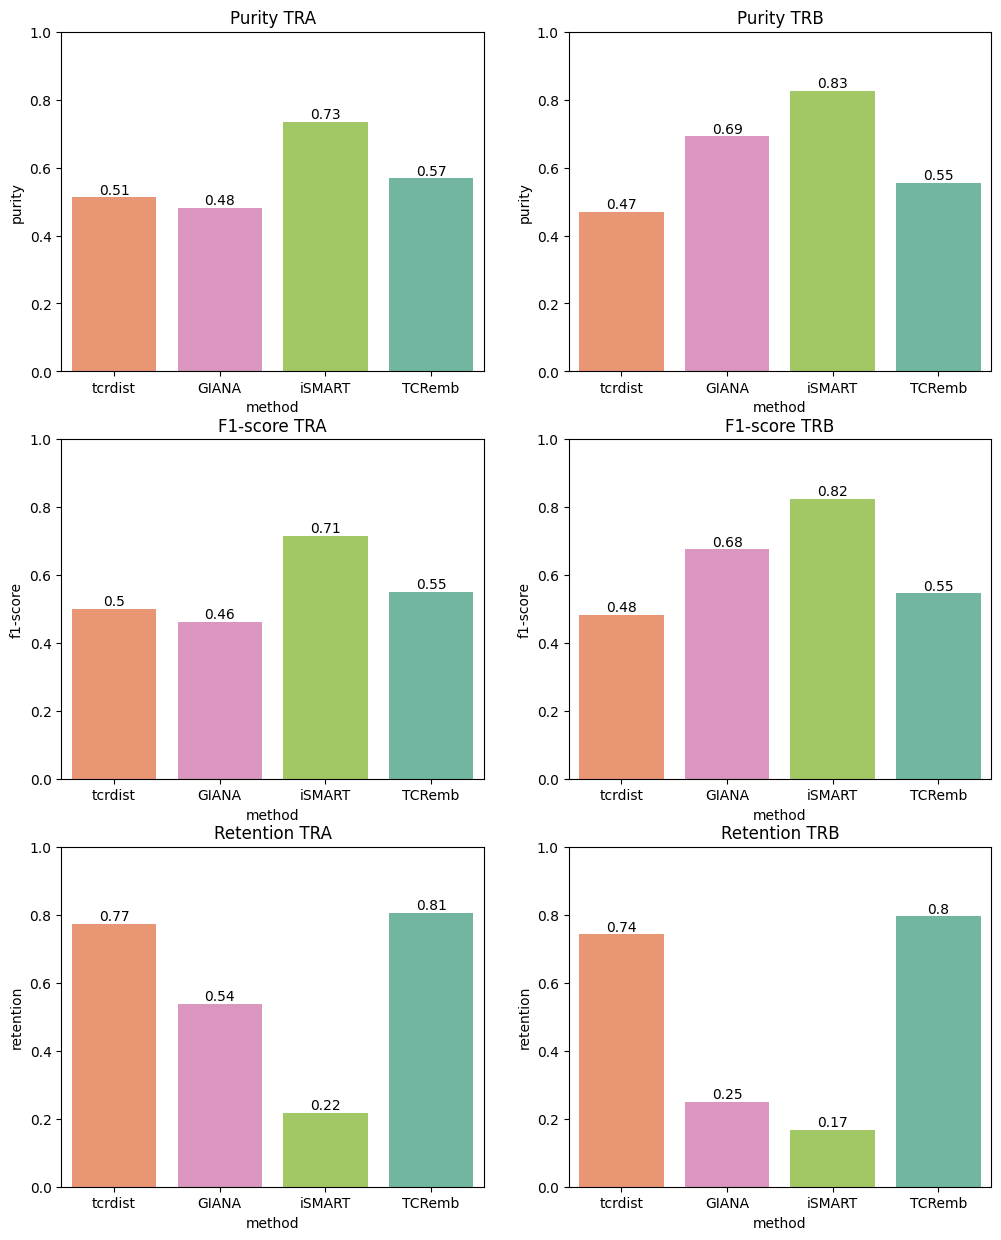

In [84]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
loc = 0
for i,r in metrics[chain].iterrows():
    axes[0,0].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,0].set_title(f'Purity {chain}')
axes[0,0].set_ylim(0, 1)

sns.barplot(data = metrics[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
loc = 0
for i,r in metrics[chain].iterrows():
    axes[1,0].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,0].set_title(f'F1-score {chain}')   
axes[1,0].set_ylim(0, 1)

sns.barplot(data = metrics[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
loc = 0
for i,r in metrics[chain].iterrows():
    axes[2,0].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,0].set_title(f'Retention {chain}') 
axes[2,0].set_ylim(0, 1)

chain = 'TRB'

sns.barplot(data = metrics[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
loc = 0
for i,r in metrics[chain].iterrows():
    axes[0,1].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,1].set_title(f'Purity {chain}')
axes[0,1].set_ylim(0, 1)

sns.barplot(data = metrics[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
loc = 0
for i,r in metrics[chain].iterrows():
    axes[1,1].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,1].set_title(f'F1-score {chain}')   
axes[1,1].set_ylim(0, 1)

sns.barplot(data = metrics[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
loc = 0
for i,r in metrics[chain].iterrows():
    axes[2,1].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,1].set_title(f'Retention {chain}') 
axes[2,1].set_ylim(0, 1)

plt.savefig(f"figures/fig4.png")

In [85]:
metrics_2 = {}

In [86]:
chain = 'TRA'
metrics_2[chain] = pd.concat([pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
           ,pd.DataFrame(metrics_giana[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb_pred_enriched[chain], index=['TCRemb'])])
metrics_2[chain]['method'] = metrics_2[chain].index

chain = 'TRB'
metrics_2[chain] = pd.concat([pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
           ,pd.DataFrame(metrics_giana[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb_pred_enriched[chain], index=['TCRemb'])])
metrics_2[chain]['method'] = metrics_2[chain].index

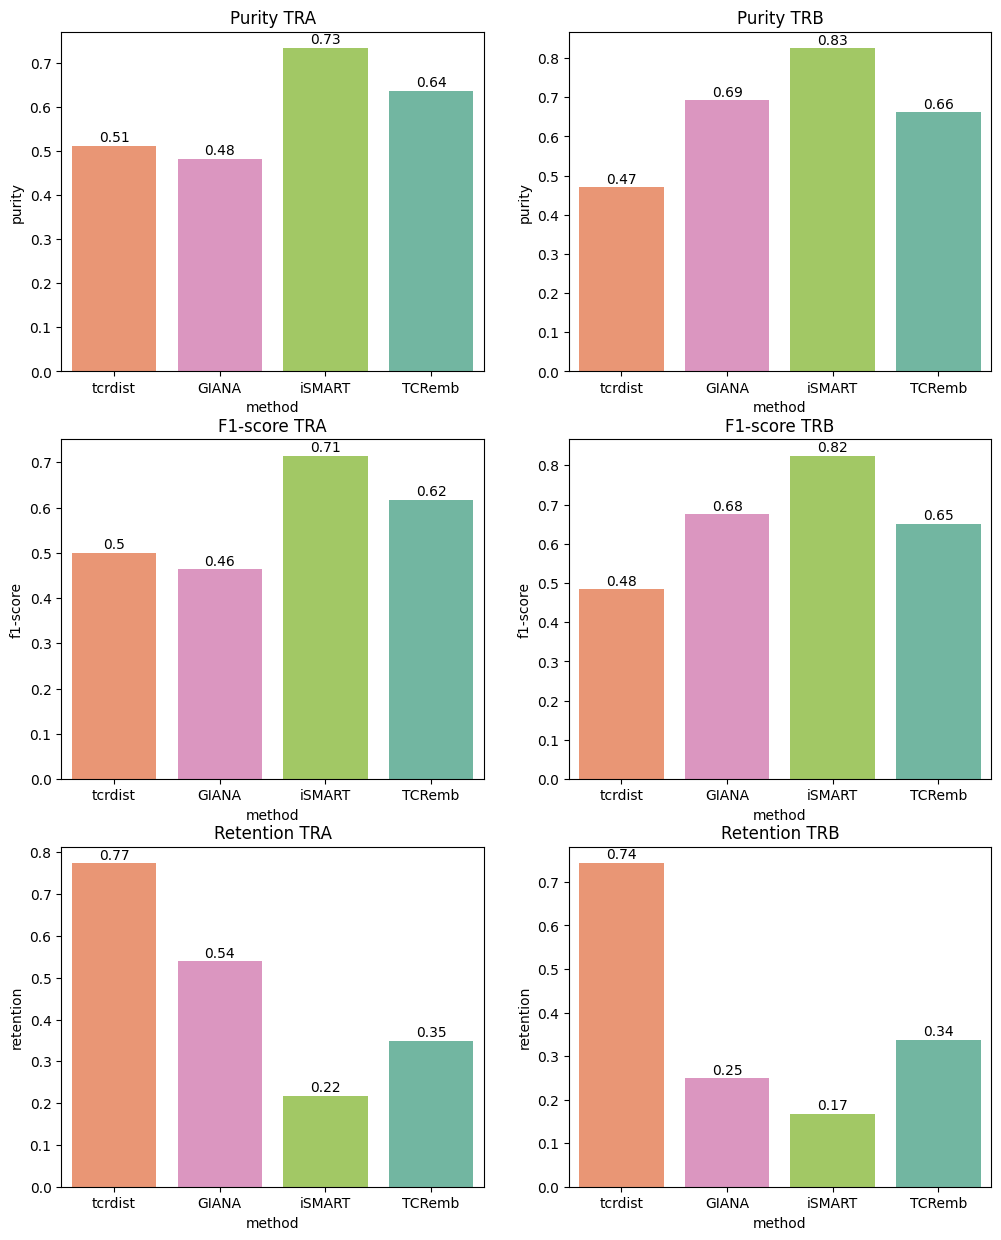

In [87]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_2[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
loc = 0
for i,r in metrics_2[chain].iterrows():
    axes[0,0].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,0].set_title(f'Purity {chain}')

sns.barplot(data = metrics_2[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
loc = 0
for i,r in metrics_2[chain].iterrows():
    axes[1,0].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,0].set_title(f'F1-score {chain}')   

sns.barplot(data = metrics_2[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
loc = 0
for i,r in metrics_2[chain].iterrows():
    axes[2,0].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,0].set_title(f'Retention {chain}') 

chain = 'TRB'

sns.barplot(data = metrics_2[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
loc = 0
for i,r in metrics_2[chain].iterrows():
    axes[0,1].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,1].set_title(f'Purity {chain}')

sns.barplot(data = metrics_2[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
loc = 0
for i,r in metrics_2[chain].iterrows():
    axes[1,1].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,1].set_title(f'F1-score {chain}')   

sns.barplot(data = metrics_2[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
loc = 0
for i,r in metrics_2[chain].iterrows():
    axes[2,1].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,1].set_title(f'Retention {chain}')   

plt.savefig(f"figures/fig4_2.png")

In [90]:
metrics_3 = {}

In [91]:
chain = 'TRA'
metrics_3[chain] = pd.concat([pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
           ,pd.DataFrame(metrics_giana[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb_pred_enriched_sq[chain], index=['TCRemb'])])
metrics_3[chain]['method'] = metrics_3[chain].index

chain = 'TRB'
metrics_3[chain] = pd.concat([pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
           ,pd.DataFrame(metrics_giana[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb_pred_enriched_sq[chain], index=['TCRemb'])])
metrics_3[chain]['method'] = metrics_3[chain].index

In [92]:
chain = 'TRA'
metrics_3[chain] = pd.concat([pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
           ,pd.DataFrame(metrics_giana[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb_pred_enriched_between[chain], index=['TCRemb'])])
metrics_3[chain]['method'] = metrics_3[chain].index

chain = 'TRB'
metrics_3[chain] = pd.concat([pd.DataFrame(metrics_tcrdist[chain], index=['tcrdist'])
           ,pd.DataFrame(metrics_giana[chain], index=['GIANA'])
           ,pd.DataFrame(metrics_ismart[chain], index=['iSMART'])
           , pd.DataFrame(metrics_tcremb_pred_enriched_between[chain], index=['TCRemb'])])
metrics_3[chain]['method'] = metrics_3[chain].index

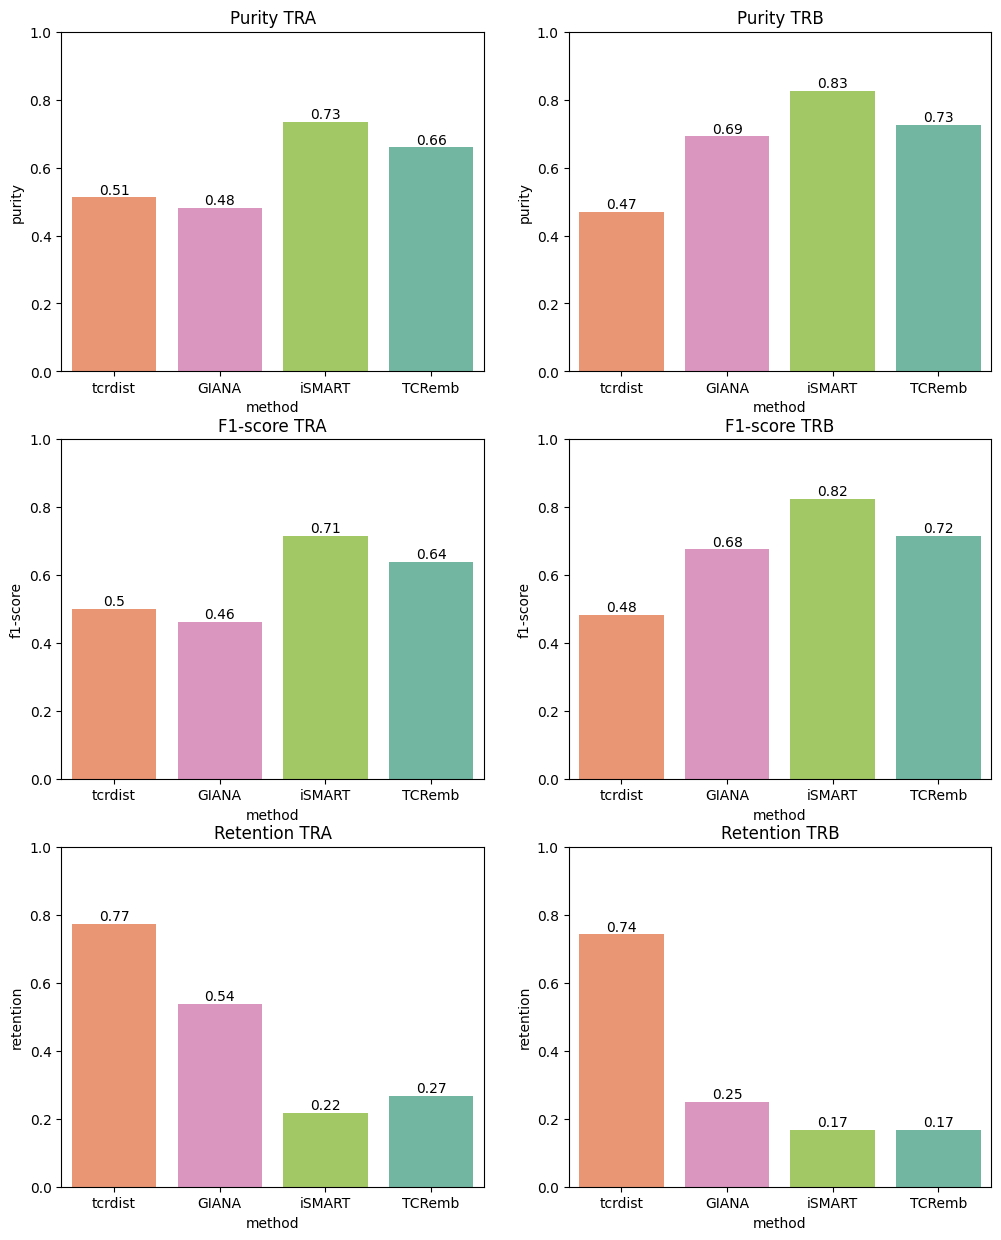

In [93]:
fig, axes = plt.subplots(3,2, figsize = (12,15))

chain = 'TRA'

sns.barplot(data = metrics_3[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,0])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[0,0].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,0].set_title(f'Purity {chain}')
axes[0,0].set_ylim(0, 1)

sns.barplot(data = metrics_3[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,0])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[1,0].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,0].set_title(f'F1-score {chain}')
axes[1,0].set_ylim(0, 1)

sns.barplot(data = metrics_3[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,0])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[2,0].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,0].set_title(f'Retention {chain}') 
axes[2,0].set_ylim(0, 1)

chain = 'TRB'

sns.barplot(data = metrics_3[chain], x = 'method', y = 'purity', palette= color_map, ax = axes[0,1])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[0,1].text(loc, r['purity'] + 0.01, round(r['purity'],2), color='black', ha="center")
    loc +=1
axes[0,1].set_title(f'Purity {chain}')
axes[0,1].set_ylim(0, 1)

sns.barplot(data = metrics_3[chain], x = 'method', y = 'f1-score', palette= color_map, ax = axes[1,1])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[1,1].text(loc, r['f1-score'] + 0.01, round(r['f1-score'],2), color='black', ha="center")
    loc +=1
axes[1,1].set_title(f'F1-score {chain}')   
axes[1,1].set_ylim(0, 1)

sns.barplot(data = metrics_3[chain], x = 'method', y = 'retention', palette= color_map, ax = axes[2,1])
loc = 0
for i,r in metrics_3[chain].iterrows():
    axes[2,1].text(loc, r['retention'] + 0.01, round(r['retention'],2), color='black', ha="center")
    loc +=1
axes[2,1].set_title(f'Retention {chain}')   
axes[2,1].set_ylim(0, 1)

plt.savefig(f"figures/fig4_3.png")

## VDJdb V10-V1000

In [4]:
#samples_n = [10,50,100,500,1000]
samples_n = [1000]

In [5]:
tcrdist_res_v = {}
metrics_tcrdist_v = {}

giana_res_raw_v = {}
giana_res_v = {}
metrics_giana_v = {}

ismart_res_raw_v = {}
ismart_res_v = {}
metrics_ismart_v = {}

tcremb_res_v = {}
metrics_tcremb_v = {}

### TCRDIST3

In [ ]:
chain = 'TRA'
for i in samples_n:
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v['v']= vdjdb_v['v'] + '*01'
    vdjdb_v['j']= vdjdb_v['j'] + '*01'
    vdjdb_v['v'] = vdjdb_v['v'].str.replace('DV','/DV')
    print(len(vdjdb_v))
    
    tcrdist_res[chain] = run_tcrdist3(vdjdb_data_tcrdist3,chain, n_clusters=5295)

### GIANA

In [13]:
## Run Giana
chain = 'TRA'
for i in samples_n:
    giana_res_raw_v[i]={}
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v['v']= vdjdb_v['v'] + '*01'
    vdjdb_v['j']= vdjdb_v['j'] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    giana_res_raw_v[i][chain] = models.run_GIANA(vdjdb_v, chain, f'V{i}',2)
    


TCR-epitope paires count in V10 dataset: 10352
GIANA clustering of 10352 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.853260
Maximum memory usage: 0.188256 MB
Elapsed time: 6.8176703453063965 seconds.
TCR-epitope paires count in V50 dataset: 9259
GIANA clustering of 9259 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.503953
Maximum memory usage: 0.188584 MB
Elapsed time: 6.396569490432739 seconds.
TCR-epitope paires count in V100 dataset: 8648
GIANA clustering of 8648 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.381646
Maximum memory usage: 0.187048 MB
Elapsed time: 6.236727476119995 seconds.
TCR-epitope paires count in V500 dataset: 5634
GIANA clustering of 5634 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 0.898809
Maximum memory usage: 0.182600 MB
Elapsed time: 5.791729927062988 seconds.
TCR-epitope paires count in V1000 dataset: 4971
GIANA clustering of 4971 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 0.839431
Maximum memory usage: 0.181128 MB
Elapsed time: 5.501701354980469 seconds.


In [14]:
## Run Giana
chain = 'TRB'
for i in samples_n:
    giana_res_raw_v[i]={}
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v['v']= vdjdb_v['v'] + '*01'
    vdjdb_v['j']= vdjdb_v['j'] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    giana_res_raw_v[i][chain] = models.run_GIANA(vdjdb_v, chain, f'V{i}',2)
    


TCR-epitope paires count in V10 dataset: 22057
GIANA clustering of 22057 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 2.089911
Maximum memory usage: 0.211128 MB
Elapsed time: 7.108323097229004 seconds.
TCR-epitope paires count in V50 dataset: 19791
GIANA clustering of 19791 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.919839
Maximum memory usage: 0.208548 MB
Elapsed time: 6.882146835327148 seconds.
TCR-epitope paires count in V100 dataset: 18072
GIANA clustering of 18072 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.791123
Maximum memory usage: 0.209748 MB
Elapsed time: 6.611473798751831 seconds.
TCR-epitope paires count in V500 dataset: 11184
GIANA clustering of 11184 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 1.091952
Maximum memory usage: 0.194924 MB
Elapsed time: 5.731211423873901 seconds.
TCR-epitope paires count in V1000 dataset: 8763
GIANA clustering of 8763 sequences.


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(



GIANA: Geometric Isometry based ANtigen-specific tcr Alignment
Ultrafast short peptide alignment exclusively designed for large-scale adaptome analysis

Input columns:
1. CDR3 amino acid sequence (Starting from C, ending with the first F/L in motif [FL]G.G)
2. Variable gene name in Imgt format: TRBVXX-XX*XX
3. Joining gene name (optional)
4. Frequency (optional)
5. Other information (optional)

!!! ALL amino acid letters must be CAPITAL !!!


Processing data.txt
Total time elapsed: 0.743410
Maximum memory usage: 0.189848 MB
Elapsed time: 5.5610010623931885 seconds.


In [15]:
## work with results
chain = 'TRA'
for i in samples_n:
    giana_res_raw_v[i]={}
    giana_res_v[i]={}
    metrics_giana_v[i]={}
    giana_res_raw_v[i][chain] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_V{i}.txt',sep='\t')
    
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v['v']= vdjdb_v['v'] + '*01'
    vdjdb_v['j']= vdjdb_v['j'] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    giana_res_v[i][chain] = vdjdb_v[vdjdb_v['chain']==chain][['chain','data_id','cdr3aa','v','antigen.epitope']].merge(giana_res_raw_v[i][chain], how = 'left')
    giana_res_v[i][chain]['is_cluster'] = giana_res_v[i][chain]['is_cluster'].fillna(0)
    
    print(ml_utils.clsf_metrics(giana_res_raw_v[i][chain]['antigen.epitope'],giana_res_raw_v[i][chain]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(giana_res_raw_v[i][chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_giana_v[i][chain] = metrics.get_clustermetrics(giana_res_v[i][chain], 'antigen.epitope')
    print(metrics_giana_v[i][chain])

TCR-epitope paires count in V10 dataset: 10352
{'f1': 0.5227617295274909, 'precision': 0.5461768198064888, 'recall': 0.548778213019959}
0.548778213019959


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.548778213019959, 'retention': 0.517870942812983, 'consistency': 0.001279420697439724, 'ami': 0.30376688325432744, 'accuracy': 0.001117732818641796, 'precision': 0.5461768198064889, 'recall': 0.5487782130199589, 'f1-score': 0.5474744262193583, 'support': 5361, 'mean_clustsize': 4.9730983302411875}
TCR-epitope paires count in V50 dataset: 9259
{'f1': 0.5722748334298549, 'precision': 0.5886703194692913, 'recall': 0.5859324585932458}
0.5859324585932458
{'purity': 0.5859324585932458, 'retention': 0.5021060589696511, 'consistency': 0.0030574931628921742, 'ami': 0.3129181087615778, 'accuracy': 0.0739096906561874, 'precision': 0.5886703194692914, 'recall': 0.5859324585932458, 'f1-score': 0.5872981982154811, 'support': 4649, 'mean_clustsize': 4.857889237199582}
TCR-epitope paires count in V100 dataset: 8648
{'f1': 0.598793952128795, 'precision': 0.6165793965555366, 'recall': 0.6112925804946336}
0.6112018669778296
{'purity': 0.6112018669778296, 'retention': 0.49549028677150786, 'con

In [16]:
## work with results
chain = 'TRB'
for i in samples_n:
    giana_res_raw_v[i]={}
    giana_res_v[i]={}
    metrics_giana_v[i]={}
    giana_res_raw_v[i][chain] = pd.read_csv(f'benchmark/outputs/giana_res_{chain}_V{i}.txt',sep='\t')
    
    vdjdb_v = pd.read_csv(f'data/data_preped/VDJdb_data_{chain}_V{i}.csv',sep='\t')
    vdjdb_v['v']= vdjdb_v['v'] + '*01'
    vdjdb_v['j']= vdjdb_v['j'] + '*01'
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    
    giana_res_v[i][chain] = vdjdb_v[vdjdb_v['chain']==chain][['chain','data_id','cdr3aa','v','antigen.epitope']].merge(giana_res_raw_v[i][chain], how = 'left')
    giana_res_v[i][chain]['is_cluster'] = giana_res_v[i][chain]['is_cluster'].fillna(0)
    
    print(ml_utils.clsf_metrics(giana_res_raw_v[i][chain]['antigen.epitope'],giana_res_raw_v[i][chain]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(giana_res_raw_v[i][chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_giana_v[i][chain] = metrics.get_clustermetrics(giana_res_v[i][chain], 'antigen.epitope')
    print(metrics_giana_v[i][chain])

TCR-epitope paires count in V10 dataset: 22057
{'f1': 0.7193003389680143, 'precision': 0.7249899616436254, 'recall': 0.7337136547662864}
0.7337136547662864


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'purity': 0.7337136547662864, 'retention': 0.24636169923380333, 'consistency': 0.0009573893978156169, 'ami': 0.6366612223330667, 'accuracy': 0.003119239012154961, 'precision': 0.7249899616436257, 'recall': 0.7337136547662855, 'f1-score': 0.7293257224323414, 'support': 5434, 'mean_clustsize': 3.5171521035598707}
TCR-epitope paires count in V50 dataset: 19791
{'f1': 0.7526459916736051, 'precision': 0.7598913887165964, 'recall': 0.7607232968881413}
0.7607232968881413
{'purity': 0.7607232968881413, 'retention': 0.2403112525895609, 'consistency': 0.0021059447047672443, 'ami': 0.6497707226753061, 'accuracy': 0.0033521465692311282, 'precision': 0.7598913887165966, 'recall': 0.7607232968881412, 'f1-score': 0.760307115239393, 'support': 4756, 'mean_clustsize': 3.5334323922734026}
TCR-epitope paires count in V100 dataset: 18072
{'f1': 0.7731527160808344, 'precision': 0.7780485863172668, 'recall': 0.7799476065729936}
0.7799476065729936
{'purity': 0.7799476065729936, 'retention': 0.23234838424081

### TCRemb

In [7]:
chain = 'TRA'
for i in samples_n:
    tcremb_res_v[i]={}
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb_res_v[i][chain] = models.run_tcremb(v_path, chain, f'V{i}',skip_scores=True)

TCR-epitope paires count in V1000 dataset: 4971
data/data_preped/VDJdb_data_TRA_V1000.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRA_V1000.csv --runname compare_V1000 --chain TRA --label antigen.epitope --data_id data_id --skip_scores True


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


clstr
skip_scores was passed as parameter. continue withot scores calculation
calculating pca of dists scores for TRA chain data/data_preped/VDJdb_data_TRA_V1000.csv
For n_clusters = 25 The average silhouette_score is : 0.1603150848987832
For n_clusters = 50 The average silhouette_score is : 0.14802710689067233
For n_clusters = 248 The average silhouette_score is : 0.15061280874885846
For n_clusters = 495 The average silhouette_score is : 0.16492684526717066
For n_clusters = 743 The average silhouette_score is : 0.17909310545874169
For n_clusters = 990 The average silhouette_score is : 0.18517511982792173
For n_clusters = 1238 The average silhouette_score is : 0.19381253637100385
For n_clusters = 1486 The average silhouette_score is : 0.19998395015737325
For n_clusters = 1981 The average silhouette_score is : 0.20658609571487438
For n_clusters = 2476 The average silhouette_score is : 0.202466668686806
For n_clusters = 2971 The average silhouette_score is : 0.1973034475259984
For n_clus

In [42]:
chain = 'TRB'
for i in samples_n:
    tcremb_res_v[i]={}
    v_path = f'data/data_preped/VDJdb_data_{chain}_V{i}.csv'
    vdjdb_v = pd.read_csv(v_path,sep='\t')
    print(f"TCR-epitope paires count in V{i} dataset: {len(vdjdb_v)}")
    print(v_path)
    
    tcremb_res_v[i][chain] = run_tcremb(v_path, chain, f'V{i}')

TCR-epitope paires count in V10 dataset: 22057
data/data_preped/VDJdb_data_TRB_V10.csv
TCRemb clustering
python tcremb_run.py --input data/data_preped/VDJdb_data_TRB_V10.csv --runname compare_V10 --chain TRB --label antigen.epitope --data_id data_id


/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


clstr
calculating dist scores for TRB chain data/data_preped/VDJdb_data_TRB_V10.csv
[κ0 CASSAFPCREGRNNEQFF, κ1 CASSHGVGQGPYEQYF, κ2 CASSLTTESGEQYF, κ3 CASSLGTLEETQYF, κ4 CASIPEGGRETQYF, κ5 CASSLDSLNTIYF, κ6 CASSQDTASSYEQYF, κ7 CASSLSYRGNSPLHF, κ8 CASSEALRDSGGQYF, κ9 CSADGLPISSYNEQFF]
(21725, 9001)
3010.0536744594574
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V10.csv
For n_clusters = 109 The average silhouette_score is : 0.09232760822885738
For n_clusters = 217 The average silhouette_score is : 0.09251468102084295
For n_clusters = 1086 The average silhouette_score is : 0.11361474566644801
For n_clusters = 2172 The average silhouette_score is : 0.1236468505627214
For n_clusters = 3259 The average silhouette_score is : 0.13211985667850557
For n_clusters = 4345 The average silhouette_score is : 0.14129369969871355
For n_clusters = 5431 The average silhouette_score is : 0.1457130170962894
For n_clusters = 6518 The average silhouette_score is : 0.1502883552

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


clstr
calculating dist scores for TRB chain data/data_preped/VDJdb_data_TRB_V50.csv
[κ0 CASSAFPCREGRNNEQFF, κ1 CASSHGVGQGPYEQYF, κ2 CASSLTTESGEQYF, κ3 CASSLGTLEETQYF, κ4 CASIPEGGRETQYF, κ5 CASSLDSLNTIYF, κ6 CASSQDTASSYEQYF, κ7 CASSLSYRGNSPLHF, κ8 CASSEALRDSGGQYF, κ9 CSADGLPISSYNEQFF]
(19526, 9001)
2720.2942731380463
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V50.csv
For n_clusters = 98 The average silhouette_score is : 0.09846692929622045
For n_clusters = 195 The average silhouette_score is : 0.09500914669084828
For n_clusters = 976 The average silhouette_score is : 0.11353282763987423
For n_clusters = 1953 The average silhouette_score is : 0.12507823666724688
For n_clusters = 2929 The average silhouette_score is : 0.1327050369655785
For n_clusters = 3905 The average silhouette_score is : 0.1400143960221537
For n_clusters = 4882 The average silhouette_score is : 0.1483318698810141
For n_clusters = 5858 The average silhouette_score is : 0.1520964813452

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


clstr
calculating dist scores for TRB chain data/data_preped/VDJdb_data_TRB_V100.csv
[κ0 CASSAFPCREGRNNEQFF, κ1 CASSHGVGQGPYEQYF, κ2 CASSLTTESGEQYF, κ3 CASSLGTLEETQYF, κ4 CASIPEGGRETQYF, κ5 CASSLDSLNTIYF, κ6 CASSQDTASSYEQYF, κ7 CASSLSYRGNSPLHF, κ8 CASSEALRDSGGQYF, κ9 CSADGLPISSYNEQFF]
(17868, 9001)
2668.6081490516663
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V100.csv
For n_clusters = 89 The average silhouette_score is : 0.0994383159326713
For n_clusters = 179 The average silhouette_score is : 0.09364402698612692
For n_clusters = 893 The average silhouette_score is : 0.11231646399688545
For n_clusters = 1787 The average silhouette_score is : 0.1245351566202473
For n_clusters = 2680 The average silhouette_score is : 0.1312669667386104
For n_clusters = 3574 The average silhouette_score is : 0.14088199817080163
For n_clusters = 4467 The average silhouette_score is : 0.14772471233887635
For n_clusters = 5360 The average silhouette_score is : 0.15391057744

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


clstr
calculating dist scores for TRB chain data/data_preped/VDJdb_data_TRB_V500.csv
[κ0 CASSAFPCREGRNNEQFF, κ1 CASSHGVGQGPYEQYF, κ2 CASSLTTESGEQYF, κ3 CASSLGTLEETQYF, κ4 CASIPEGGRETQYF, κ5 CASSLDSLNTIYF, κ6 CASSQDTASSYEQYF, κ7 CASSLSYRGNSPLHF, κ8 CSADGLPISSYNEQFF, κ9 CASSFRQGAFGDTQYF]
(11144, 9001)
1623.0583646297455
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V500.csv
For n_clusters = 56 The average silhouette_score is : 0.10874644155667842
For n_clusters = 111 The average silhouette_score is : 0.10092901950886876
For n_clusters = 557 The average silhouette_score is : 0.11638289439513053
For n_clusters = 1114 The average silhouette_score is : 0.123087335044367
For n_clusters = 1672 The average silhouette_score is : 0.13160720355976577
For n_clusters = 2229 The average silhouette_score is : 0.14039925241305523
For n_clusters = 2786 The average silhouette_score is : 0.14510716141454694
For n_clusters = 3343 The average silhouette_score is : 0.146892843

/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/home/ykremlyakova/.conda/envs/py311/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


clstr
calculating dist scores for TRB chain data/data_preped/VDJdb_data_TRB_V1000.csv
[κ0 CASSAFPCREGRNNEQFF, κ1 CASSLTTESGEQYF, κ2 CASSLGTLEETQYF, κ3 CASSLDSLNTIYF, κ4 CASSQDTASSYEQYF, κ5 CSADGLPISSYNEQFF, κ6 CASSFRQGAFGDTQYF, κ7 CASSFGPRAGTTGELFF, κ8 CSASTTTGLAPVEQYF, κ9 CASSYGTGKDFEQFF]
(8743, 9001)
1209.268597126007
calculating pca of dists scores for TRB chain data/data_preped/VDJdb_data_TRB_V1000.csv
For n_clusters = 44 The average silhouette_score is : 0.10896030655034021
For n_clusters = 87 The average silhouette_score is : 0.1004795142417115
For n_clusters = 437 The average silhouette_score is : 0.10577339222360715
For n_clusters = 874 The average silhouette_score is : 0.11489595409089592
For n_clusters = 1311 The average silhouette_score is : 0.12213551917710323
For n_clusters = 1749 The average silhouette_score is : 0.1289889086033662
For n_clusters = 2186 The average silhouette_score is : 0.13642847280377762
For n_clusters = 2623 The average silhouette_score is : 0.13734642

In [8]:
## work with results
chain = 'TRA'
for i in samples_n:
    tcremb_res_v[i]={}
    metrics_tcremb_v[i]={}
    tcremb_res_v[i][chain] = pd.read_csv(f'tcremb_outputs/compare_V{i}/tcremb_clstr_res_{chain}.txt',sep='\t')

    print(f"TCR-epitope paires count in V{i} dataset: {len(tcremb_res_v[i][chain])}")
    
    print(ml_utils.clsf_metrics(tcremb_res_v[i][chain]['antigen.epitope'],tcremb_res_v[i][chain]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(tcremb_res_v[i][chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_tcremb_v[i][chain] = metrics.get_clustermetrics(tcremb_res_v[i][chain], 'antigen.epitope')
    print(metrics_tcremb_v[i][chain])

TCR-epitope paires count in V1000 dataset: 4964
{'f1': 0.82619252652972, 'precision': 0.8263189551735587, 'recall': 0.8261482675261885}
0.8982889733840305
{'purity': 0.8982889733840305, 'retention': 0.2119258662369057, 'consistency': 0.019486692015209126, 'ami': 0.48934987288187354, 'accuracy': 0.2945909656059796, 'precision': 0.8973945977272973, 'recall': 0.8982889733840305, 'f1-score': 0.8978415628249367, 'support': 1052, 'mean_clustsize': 3.460526315789474}


In [44]:
## work with results
chain = 'TRB'
for i in samples_n:
    tcremb_res_v[i]={}
    metrics_tcremb_v[i]={}
    tcremb_res_v[i][chain] = pd.read_csv(f'tcremb_outputs/compare_V{i}/tcremb_clstr_res_{chain}.txt',sep='\t')

    print(f"TCR-epitope paires count in V{i} dataset: {len(tcremb_res_v[i][chain])}")
    
    print(ml_utils.clsf_metrics(tcremb_res_v[i][chain]['antigen.epitope'],tcremb_res_v[i][chain]['label_cluster'], average='weighted'))
    print(ml_utils.count_clstr_purity(tcremb_res_v[i][chain][['cluster','label_cluster','total_cluster','count_matched','fraction_matched','p_value','fraction_matched_exp','is_cluster']].drop_duplicates()))
    
    metrics_tcremb_v[i][chain] = metrics.get_clustermetrics(tcremb_res_v[i][chain], 'antigen.epitope')
    print(metrics_tcremb_v[i][chain])

TCR-epitope paires count in V10 dataset: 22038
{'f1': 0.6590495956433875, 'precision': 0.6675101493820986, 'recall': 0.6627643161811416}
0.5783980031767643
{'purity': 0.5783980031767643, 'retention': 0.7998910971957528, 'consistency': 0.00023370549574778287, 'ami': 0.40694636587814487, 'accuracy': 0.0045722849022758055, 'precision': 0.576235001922712, 'recall': 0.5783980031767643, 'f1-score': 0.5773144765490935, 'support': 17628, 'mean_clustsize': 3.4235773936686735}
TCR-epitope paires count in V50 dataset: 19774
{'f1': 0.617070423087933, 'precision': 0.6199579191786735, 'recall': 0.6228380701931829}
0.5737311385459534
{'purity': 0.5737311385459534, 'retention': 0.8847982198846971, 'consistency': 0.0003937407915460041, 'ami': 0.3724118515931559, 'accuracy': 0.0048890004304857505, 'precision': 0.5662400412766414, 'recall': 0.5737311385459533, 'f1-score': 0.5699609767722585, 'support': 17496, 'mean_clustsize': 3.6825931382866766}
TCR-epitope paires count in V100 dataset: 18056
{'f1': 0.6

In [40]:
def run_tcremb(data_path, chain, output_suf, skip_scores=False):
    run_name = f'compare_{output_suf}'
    label_cl = 'antigen.epitope'
    
    #cdir = os.getcwd()
    print('TCRemb clustering')

    # Run TCRemb
    t0 = time.time()
    command = f'python tcremb_run.py --input {data_path} --runname {run_name} --chain {chain} --label {label_cl} --data_id data_id'
    print(command)
    os.system(command)
    t1 = time.time()
    t = t1 - t0

    print('Elapsed time: {} seconds.'.format(t))

    tcremb_data = pd.read_csv(f'tcremb_outputs/{run_name}/tcremb_clstr_res_{chain}.txt')
    #tcremb_data.to_csv(f'benchmark/outputs/tcremb_res_{chain}_{output_suf}.txt',sep='\t', index=False)

    return tcremb_data

# Classification

## ATM_TCR

2650 11772 505 6706
accuracy   0.4325
auc        0.6519
f1macro    0.4118
f1micro    0.4325
loss       442818.7955
precision0 0.8399
precision1 0.3629
recall0    0.1837
recall1    0.9300

In [9]:
atm_results_path = '/home/ykremlyakova/apps/ATM-TCR/result/pred_my_model_vdjdb_trb_atmtcr_test.csv'
real_test_path = '/home/ykremlyakova/projects/tcr_emb/data/data_preped/vdjdb_trb_atmtcr_test.csv'

In [8]:
!pwd

/home/ykremlyakova/projects/tcr_emb


In [14]:
real_test = pd.read_csv(real_test_path,header=None)
real_test

,0,1,2
0,NLVPMVATV,CASSFPLGGTYEQYF,1
1,NLVPMVATV,CASSLGLDTQYF,1
2,NLVPMVATV,CSARDLDRADNTGELFF,1
3,GTSGSPIVNR,CASLSGRAPQHF,1
4,NLVPMVATV,CASSLNYEQYF,1
...,...,...,...
21628,ELAGIGILTV,CASSPGEARGEQFF,0
21629,TTDPSFLGRY,CASSPGTLSTEAFF,0
21630,QYIKWPWYI,CASSSSFLGNQPQHF,0
21631,NLVPMVATV,CASSRFPTGSNNEQFF,0


In [17]:
atm = pd.read_csv(atm_results_path, sep='\t',header=None)
atm = atm.rename({0:'antigen.epitope',1:'cdr3aa',2:'bind',3:'pred'},axis=1)

In [19]:
epitopes_list = ['CINGVCWTV',
 'ELAGIGILTV',
 'FRDYVDRFYKTLRAEQASQE',
 'GILGFVFTL',
 'GLCTLVAML',
 'KRWIILGLNK',
 'LLLGIGILV',
 'LLWNGPMAV',
 'NLVPMVATV',
 'PKYVKQNTLKLAT',
 'SPRWYFYYL',
 'TFEYVSQPFLMDLE',
 'TPRVTGGGAM',
 'TTDPSFLGRY',
 'YLQPRTFLL']

In [31]:
atm_e = atm[atm['antigen.epitope'].isin(epitopes_list)]

In [23]:
#atm_e = atm_e[atm_e['bind']==1]

In [42]:
roc_res = []
for e in epitopes_list:
    r={}
    r['class']= e
    r['roc_auc'] = ml_utils.roc_auc_count_binary(atm_e[atm_e['antigen.epitope']==e]['bind'], atm_e[atm_e['antigen.epitope']==e]['pred'])
    roc_res.append(r)

In [43]:
roc_res


[{'class': 'CINGVCWTV', 'roc_auc': 0.5752120257985882},
 {'class': 'ELAGIGILTV', 'roc_auc': 0.515489498116114},
 {'class': 'FRDYVDRFYKTLRAEQASQE', 'roc_auc': 0.677350859453994},
 {'class': 'GILGFVFTL', 'roc_auc': 0.5704231955814368},
 {'class': 'GLCTLVAML', 'roc_auc': 0.5417590286425903},
 {'class': 'KRWIILGLNK', 'roc_auc': 0.5725415070242657},
 {'class': 'LLLGIGILV', 'roc_auc': 0.5764722698684963},
 {'class': 'LLWNGPMAV', 'roc_auc': 0.5477210630899155},
 {'class': 'NLVPMVATV', 'roc_auc': 0.5250316938946034},
 {'class': 'PKYVKQNTLKLAT', 'roc_auc': 0.5584946899431166},
 {'class': 'SPRWYFYYL', 'roc_auc': 0.5273414985590779},
 {'class': 'TFEYVSQPFLMDLE', 'roc_auc': 0.730540427314621},
 {'class': 'TPRVTGGGAM', 'roc_auc': 0.6228962818003914},
 {'class': 'TTDPSFLGRY', 'roc_auc': 0.5266290726817043},
 {'class': 'YLQPRTFLL', 'roc_auc': 0.6320013101867017}]

In [30]:
atm_e[atm_e['pred'].isna()]

,antigen.epitope,cdr3aa,bind,pred,4
